# model-based collaborative filtering with svd

using http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('precision',2)

In [7]:
data_path = '../ml-100k'
all_files = [i for i in os.listdir(data_path) if i.endswith('.csv') or i.startswith('u.')]
print(all_files)

['u.item', 'u.data', 'u.occupation', 'u.genre', 'u.info', 'u.user']


In [19]:
def get_data(fn, header):
    df = pd.read_csv(os.path.join(data_path, 'u.{}'.format(fn)), sep='\t', names=header)
    print('{} total: {} rows.'.format(fn, len(df)))
    return df

In [26]:
header = ['user_id', 'movie_id', 'rating', 'timestamp']
data = get_data('data', header)
data.head(5)

data total: 100000 rows.


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Total users: 943.


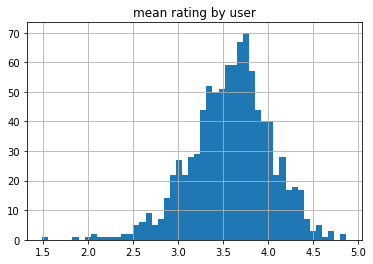

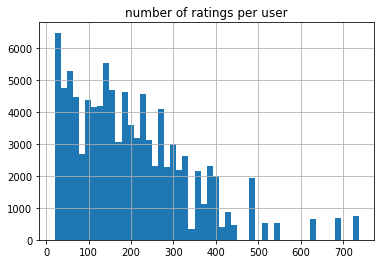

In [51]:
print('Total users: {}.'.format(len(data.user_id.unique())))
data.groupby('user_id').rating.mean().hist(bins=50)
plt.title('mean rating by user')
plt.figure()
data.groupby('user_id').rating.transform(lambda x: len(x)).hist(bins=50)
plt.title('number of ratings per user')

Total movies: 1682.


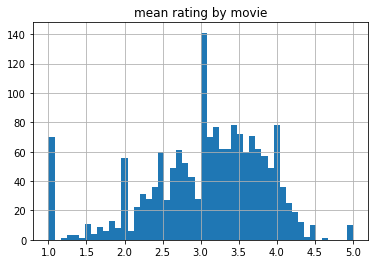

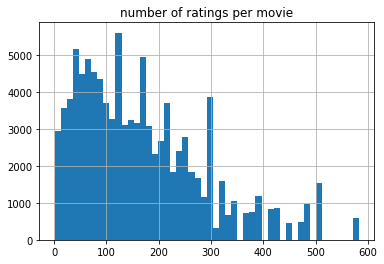

In [50]:
print('Total movies: {}.'.format(len(data.movie_id.unique())))
data.groupby('movie_id').rating.mean().hist(bins=50)
plt.title('mean rating by movie')
plt.figure()
data.groupby('movie_id').rating.transform(lambda x: len(x)).hist(bins=50)
plt.title('number of ratings per movie')

In [37]:
# shuffle data and use the last 20% as test set
data = data.sample(frac=1)
total = len(data)
train = data.head(int(0.8*total))
test = data.tail(int(0.2*total))

In [52]:
n_users = len(data.user_id.unique())
n_movies = len(data.movie_id.unique())

In [60]:
# silly tests for checking if user and movie ids are consecutive and complete
print([i for i in range(n_users) if i not in data.user_id.unique()])
print([i for i in data.user_id.unique() if i not in range(n_users)])
print([i for i in range(n_movies) if i not in data.movie_id.unique()])
print([i for i in data.movie_id.unique() if i not in range(n_movies)])

[]
[]
[]
[]


In [59]:
# oh, so we have to go from 1-based to 0-based, eh?
data.user_id = data.user_id - 1
data.movie_id = data.movie_id - 1

## memory based collaborative filtering

In [66]:
train_matrix = pd.crosstab(train.user_id, train.movie_id).as_matrix()
test_matrix = pd.crosstab(test.user_id, test.movie_id).as_matrix()

In [70]:
from sklearn.metrics.pairwise import pairwise_distances
train_us = pairwise_distances(train_matrix, metric='cosine')
train_ms = pairwise_distances(train_matrix.T, metric='cosine')

In [71]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)[:, np.newaxis]
        ratings_diff = (ratings - mean_user_rating)
        pred = mean_user_rating + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'movie':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    else:
        print('Unknown type.')
        pred = None
    return pred

In [82]:
movie_pred = predict(train_matrix, train_ms, 'movie')

In [83]:
user_pred = predict(train_matrix, train_us, 'user')

In [84]:
from sklearn.metrics import mean_squared_error

In [91]:
def rmse(y_pred, y):
    y_pred = y_pred[y.nonzero()].flatten()
    y = y[y.nonzero()].flatten()
    return np.sqrt(mean_squared_error(y, y_pred))

In [90]:
# benchmark: netflix tried to go from 0.9525 to 0.8572 or less and paid 1 million dollars for it

print('Root mean squared error of user based collaborative filtering: {:.3f}'.format(rmse(user_pred, test_matrix)))
print('Root mean squared error of item based collaborative filtering: {:.3f}'.format(rmse(movie_pred, test_matrix)))

Root mean squared error of user based collaborative filtering: 0.809
Root mean squared error of item based collaborative filtering: 0.900


## model based collaborative filtering

In [95]:
# sparsity level of the dataset
sparsity = round(1-len(data)/(n_users*n_movies),3)
sparsity

0.937

In [96]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [110]:
# convert to sparse float matrix
train_sparse = sp.coo_matrix.asfptype(sp.csr_matrix(train_matrix))

In [114]:
u, s, vt = svds(train_sparse, k=20)
s_diag = np.diag(s)
X_pred = np.dot(np.dot(u, s_diag), vt)
rmse(X_pred, test_matrix)

0.90840903479105395